In [29]:
import pandas as pd
import numpy as np

import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [30]:
# read df
df = pd.read_csv('hw_bootstrap.csv', sep=';')

In [31]:
# check missing values
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [32]:
# check dtypes
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [33]:
# convert object to float
df.value = df.value.apply(lambda x: x.replace(',', '.'))
df.value = df.value.astype(float)
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [34]:
df.loc[df.experimentVariant == 'Control'].shape

(500, 3)

In [35]:
df.loc[df.experimentVariant == 'Treatment'].shape

(500, 3)

Both groups contain the same number of observations.

Let's check the distributions for both groups.

Text(0.5, 0, 'value')

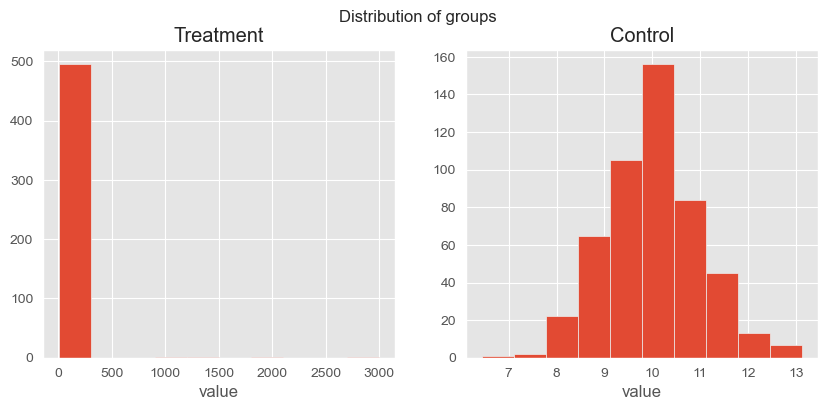

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Distribution of groups')

df[df.experimentVariant == 'Treatment'].value.hist(ax=axes[0])
axes[0].set_title('Treatment')
axes[0].set_xlabel("value")
df[df.experimentVariant == 'Control'].value.hist(ax=axes[1])
axes[1].set_title('Control')
axes[1].set_xlabel("value")

In the control group, the distribution looks similar to normal, but not in the test group.

Since most of the observations in the test group are concentrated on the left side of the histogram, one can try to apply the logarithm

Text(0.5, 0, 'value')

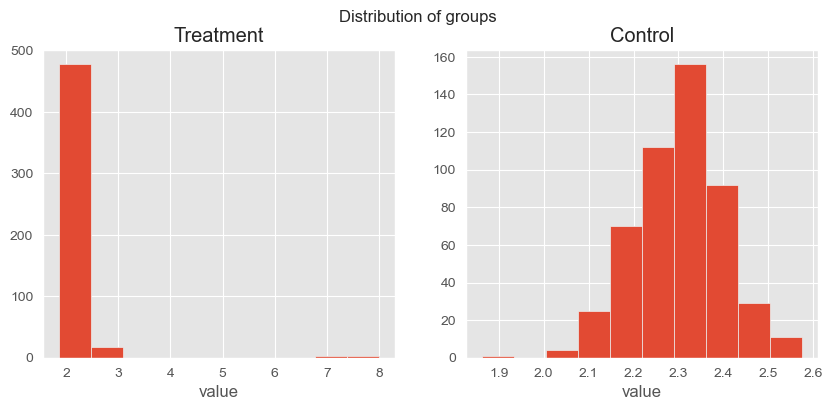

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Distribution of groups')

np.log(df[df.experimentVariant == 'Treatment'].value).hist(ax=axes[0])
axes[0].set_title('Treatment')
axes[0].set_xlabel("value")
np.log(df[df.experimentVariant == 'Control'].value).hist(ax=axes[1])
axes[1].set_title('Control')
axes[1].set_xlabel("value")

As can be seen from the results obtained, the logarithm also does not allow obtaining a sample with a normal distribution.

Let's check the normality of the original distributions using the Shapiro-Wilk test

In [38]:
pg.normality(df, dv='value', group='experimentVariant', method='normaltest')

,W,pval,normal
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


As one can see, the test confirms the normality of the distribution in the Control group, but not in the test group.

Let us also check the homogeneity of the variance in the groups.

In [39]:
pg.homoscedasticity(df, dv='value', group='experimentVariant')

,W,pval,equal_var
levene,4.297837,0.038417,False


The variances in our groups differ significantly.

Let's check QQ-charts, as well as boxplots.

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

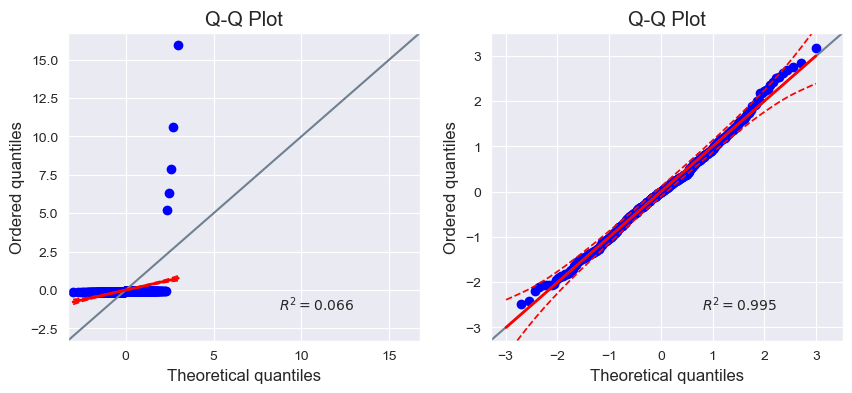

In [40]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pg.qqplot(df[df.experimentVariant == 'Treatment'].value, dist='norm', ax=axes[0])
pg.qqplot(df[df.experimentVariant == 'Control'].value, dist='norm', ax=axes[1])

<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

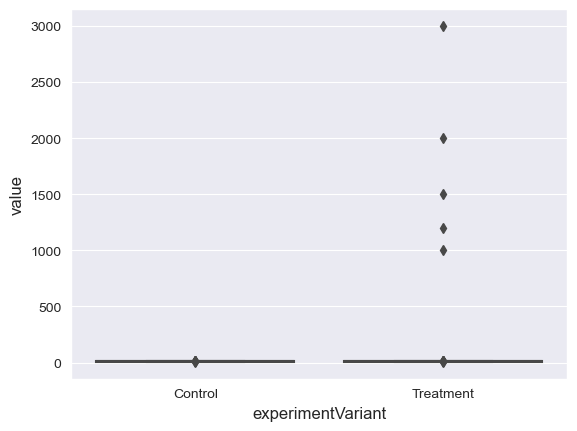

In [41]:
sns.boxplot(data=df, x='experimentVariant', y='value', orient="v")

t can be seen that there are outliers in the Treatment distribution.

Based on the fact that the requirements for the application of the t-test are not met, it can be concluded that the t-test will give unreliable results.

In [42]:
pg.ttest(df[df.experimentVariant == 'Treatment'].value, df[df.experimentVariant == 'Control'].value)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.072902,998,two-sided,0.038438,"[0.92, 33.67]",0.131102,0.586,0.544197


In the t-test, p_value is 0.038438 and corresponds to a statistically significant difference. But these results cannot be trusted for the above reasons.

Let us apply instead of the t-test, the Mann-Whitney U-test, which does not require normal distributions.

In [43]:
pg.mwu(df[df.experimentVariant == 'Treatment'].value, df[df.experimentVariant == 'Control'].value)

,U-val,alternative,p-val,RBC,CLES
MWU,125810.5,two-sided,0.859215,-0.006484,0.503242


In this test, p_value=0.859215, i.e. the observed differences are not statistically significant and the null hypothesis cannot be rejected.

However, the U-test can only be applied if there are no matching values in the sample data, or if the number of matches is less than 10

The previously constructed distribution showed that many of the sample values belong to the same interval. Let's check the number of unique values by rounding the sample values to 2 decimal places.

In [44]:
df[df.experimentVariant == 'Treatment'].value.round(2).nunique()

281

Thus, I assume that the results of the U-test are also not to be trusted.

We will use the bootstrap because it allows one to test hypotheses without focusing on the sample distribution.

In [45]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, ок
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

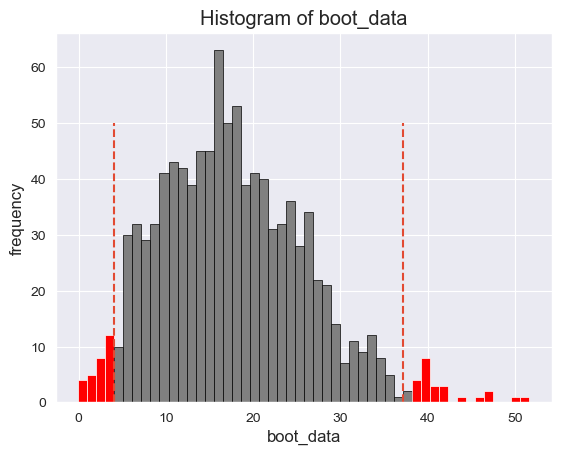

In [46]:
booted_data = get_bootstrap(df[df.experimentVariant == 'Treatment'].value, df[df.experimentVariant == 'Control'].value)

In [47]:
booted_data["p_value"] 

0.03630380998260881

In [48]:
booted_data["quants"]

,0
0.025,3.998783
0.975,37.176138


As a result of applying this test, we confirmed statistically significant differences (p_value = 0.03630380998260881). So there is reason to reject the null hypothesis. There is no reason not to trust this result.

__Conclusions:
Probability values obtained in tests: t-test p_value=0.038438, U-test p_value=0.859215, bootstrap p_value=0.03630380998260881__

__In two tests out of three, we confirmed statistically significant differences. However, not both samples satisfy the criterion of normality of distribution, and the requirement of homogeneity of the variance is also not met. This limits the application of the t-test. In addition, there are a sufficient number of similar values in the Treatment sample, which limits the use of the U-test. In both of these tests, it is also required to confirm independent samples, which can be additionally done. The bootstrap does not require the independence of the samples and the normality of the distribution, therefore, to test the zero hypothesis in this problem, it is worth choosing in favor of the bootstrap. According to its results, the differences found are statistically significant. Although, since there are outliers in the sample, it is additionally possible to conduct a study with the median, since it is less sensitive to them than the mean.__